In [2]:
using Pkg
Pkg.activate("C:/Users/ibzja/Documents/UPF_2022_2026/4t/2n_trimestre/Practiques_tutelades/CellBasedModels.jl")
using CellBasedModels 
using GeometryBasics
using Distributions
using GLMakie
Makie.inline!(true)
using CSV, DataFrames, Statistics

  Activating project at `C:\Users\ibzja\Documents\UPF_2022_2026\4t\2n_trimestre\Practiques_tutelades\CellBasedModels.jl`


In [3]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :v => Float64,  #Swimming speed
        :theta => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        :active => Bool,

        :isSource => Bool, 
        :S => Float64,

        :methyl => Float64, #Receptor methylation
        :Yp => Float64, #CheYP levels, probability of tumblingç
        :G => Float64,
        :λ => Float64,
        :P => Float64,
        :M => Float64,
        :F => Float64,
        :A => Float64,
        :M => Float64
        
    ),

    model = Dict(

        :Dr_run => Float64,

        :ε0 => Float64, #Energy parameters
        :ε1 => Float64,
        :ε2 => Float64,
        :ε3 => Float64,
        :K => Float64,
        :Nrec => Float64, #Cooperativity
        :Ki => Float64, #Dissociation constants
        :Ka => Float64,
        :τm => Float64, #Methylation adaptation timescale
        :α => Float64,      #Total Yp pool
        :ωFrec => Float64,     #Basal switching frequency
        :Ky => Float64,         #CheA - CheY phosphorylation rate
        :Z => Float64,          #CheZ concentration
        :Kz => Float64,         #CheZ mediated dephosphorylation rate
        :Yy => Float64,         #Basa Yp leak

        :DMedium => Float64
    ),

    medium = Dict(
        :mm => Float64
    ),

    agentODE = quote

        F = ε0 + ε1 * methyl + Nrec * log((1 + mm / Ki) / (1 + mm / Ka)) #Equació del paper per definir activitat del receptor
        F0 = log(((Ky * (α - K)) / (K * (Kz * Z + Yy))) - 1)        #Energia lliure en estat adaptat

        mx = (ε0 + Nrec * log((1 + mm / Ki) / (1 + mm / Ka)) - F0) / (- ε1)

        A = 1 / (1 + exp(F))    

        Yp = (Ky * A * α) / ((Ky * A) + (Kz * Z) + Yy)

        G = ε2 / 4 - (ε3 / 2) / (1 + (K / Yp))      #CheYp segons activitat receptor

        dt(x) = active * vx  #Change position acording to constant speed afected by forces
        dt(y) = active * vy  
        dt(methyl) = -(1 / τm) * (methyl - mx)        #Methylation
        
    end,

    agentRule = quote

        if isSource
            active = false
            x = 0.3
            y = 0.3
            vx = 0.0
            vy = 0.0
            mm += S  
        else

            if active
                # λrt = ωFrec*exp(-G)*dt 
                λrt = ωFrec*exp(-G)
                P_rt = 1 - exp(-λrt * dt)
                P = rand() 
                                        #Si rate alta = mes probabilitat de canvi. Per tant, si random number mes petit =  canvi. 
                if P < P_rt             #Si rate alta = mes probabilitat de canvi. Per tant, si random number mes petit =  canvi. 
                    active = false
                    vx = 0
                    vy = 0
                    theta = rand(Uniform(0, 2π))            #Tumble = random reorientation
                else     #Si rate baixa 
                    active = true
                    vx = v * cos(theta)
                    vy = v * sin(theta)
                    theta += sqrt(2 * Dr_run * dt) * randn()        #Keep running, reorientation according to rotational difusion
                end

            else
                # λtr = ωFrec*exp(G) *dt
                λtr = ωFrec*exp(G)
                P_tr = 1 - exp(-λtr * dt)
                P = rand()
        
                if P < P_tr
                    active = true
                    vx = v * cos(theta)
                    vy = v * sin(theta)
                    theta += sqrt(2 * Dr_run * dt) * randn()
                else
                    active = false
                    vx = 0
                    vy = 0
                    theta = rand(Uniform(0, 2π))
                end
                
            end
        end

        if x < simBox[1,1]
            x = simBox[1,1]
            # theta = pi - theta   
        elseif x > simBox[1,2]
            x = simBox[1,2]
            # theta = pi - theta
        end
        if y < simBox[2,1]
            y = simBox[2,1]
            # theta = -theta/2
        elseif y > simBox[2,2]
            y = simBox[2,2]
            # theta = -theta/2
        end

    end,

    mediumODE = quote
        if @mediumInside()
            dt(mm) = DMedium *(@∂2(1, mm)+ @∂2(2, mm))
        end
    end,

    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)

PARAMETERS
	x (Float64 agent)
	y (Float64 agent)
	xₘ (Float64 medium)
	yₘ (Float64 medium)
	F (Float64 agent)
	active (Bool agent)
	methyl (Float64 agent)
	l (Float64 agent)
	S (Float64 agent)
	M (Float64 agent)
	d (Float64 agent)
	λ (Float64 agent)
	v (Float64 agent)
	isSource (Bool agent)
	A (Float64 agent)
	fx (Float64 agent)
	vx (Float64 agent)
	fy (Float64 agent)
	m (Float64 agent)
	Yp (Float64 agent)
	P (Float64 agent)
	pressure (Float64 agent)
	vy (Float64 agent)
	W (Float64 agent)
	G (Float64 agent)
	theta (Float64 agent)
	ε1 (Float64 model)
	α (Float64 model)
	Z (Float64 model)
	Dr_run (Float64 model)
	Ka (Float64 model)
	ε3 (Float64 model)
	ε0 (Float64 model)
	DMedium (Float64 model)
	Ky (Float64 model)
	Kz (Float64 model)
	K (Float64 model)
	ε2 (Float64 model)
	Nrec (Float64 model)
	τm (Float64 model)
	Yy (Float64 model)
	Ki (Float64 model)
	ωFrec (Float64 model)
	mm (Float64 medium)


UPDATE RULES
mediumODE
 if @mediumInside()
    dt__mm = DMedium * (@∂2(1, mm) + @∂2(2, mm)

In [14]:
com = Community(
    rods2DChemotaxis,
    N=20,
    # dt=0.1,
    dt=0.01,
    simBox = [-20.0 20.0; -20.0 20.0],
    # simBox = [-50.0 50.0; -50.0 50.0],
    # NMedium = [250, 250]
    NMedium = [100, 100]
)

m = 1/100
g = 1/10000
d = 1

com.Dr_run = 0.062

com.v = 20.0
# com.v = 10.0
# com.v = 5.0
# com.v = 2.5
# com.v = 1
# com.v = 0.1

com.DMedium = 500
# com.DMedium = 1000
# com.DMedium = 0.01
# com.DMedium = 0.001
# com.DMedium = 0.0001

com.ωFrec = 1.3
com.Ki = 0.0182
com.Ka = 3.0
com.Nrec = 6.0
com.ε0   = 6.0
com.ε1   = -1.0
com.ε2   = 80
com.ε3   = 80

# com.τm = 5.0
com.τm = 10.0
# com.τm = 30.0

com.α   = 6.0

com.K = 2.0 

com.Ky = 100.0
com.Kz = 10.0
com.Z = 5.0
com.Yy = 0.1

com.m = 1.        
com.d = 1.        
com.l = 3;

com.x = rand(Uniform(com.simBox[1,:]...),com.N)
com.y = rand(Uniform(com.simBox[2,:]...),com.N)
com.theta = rand(Uniform(0,2π),com.N)

com.methyl .= 0.0
com.Yp .= com.K

src = 1

com.x[src] = 0.3
com.y[src] = 0.3

com.isSource .= false
com.isSource[src] = true

com.active .= true 
com.active[src] = false   

com.S .= 0.0

# com.S[src] = 10
com.S[src] = 100
# com.S[src] = 1000


100

In [ ]:
outfile = "test_1.csv"
data = DataFrame(
    step = Int[],
    id = Int[],
    x = Float64[],
    y = Float64[],
    theta = Float64[],
    l = Float64[],
    d = Float64[],
    active = Bool[],
    isSource = Bool[],
    mm_grid = Any[]
)


steps = 10000
saveEach = 10
loadToPlatform!(com, preallocateAgents=20)       #Preallocate agents = number of agents in community
com.mm = zeros(Float64, com.NMedium...)  

for step in 1:steps 
    step!(com)
    if step % saveEach == 0
        mm_grid_flat = copy(vec(com.mm))

        for i in 1:com.N
            push!(data, (
                step, 
                i,
                com.x[i],
                com.y[i],
                com.theta[i],
                com.l[i],
                com.d[i],
                com.active[i],
                com.isSource[i],
                mm_grid_flat
            ))
        end
    end
end

CSV.write(outfile, data)

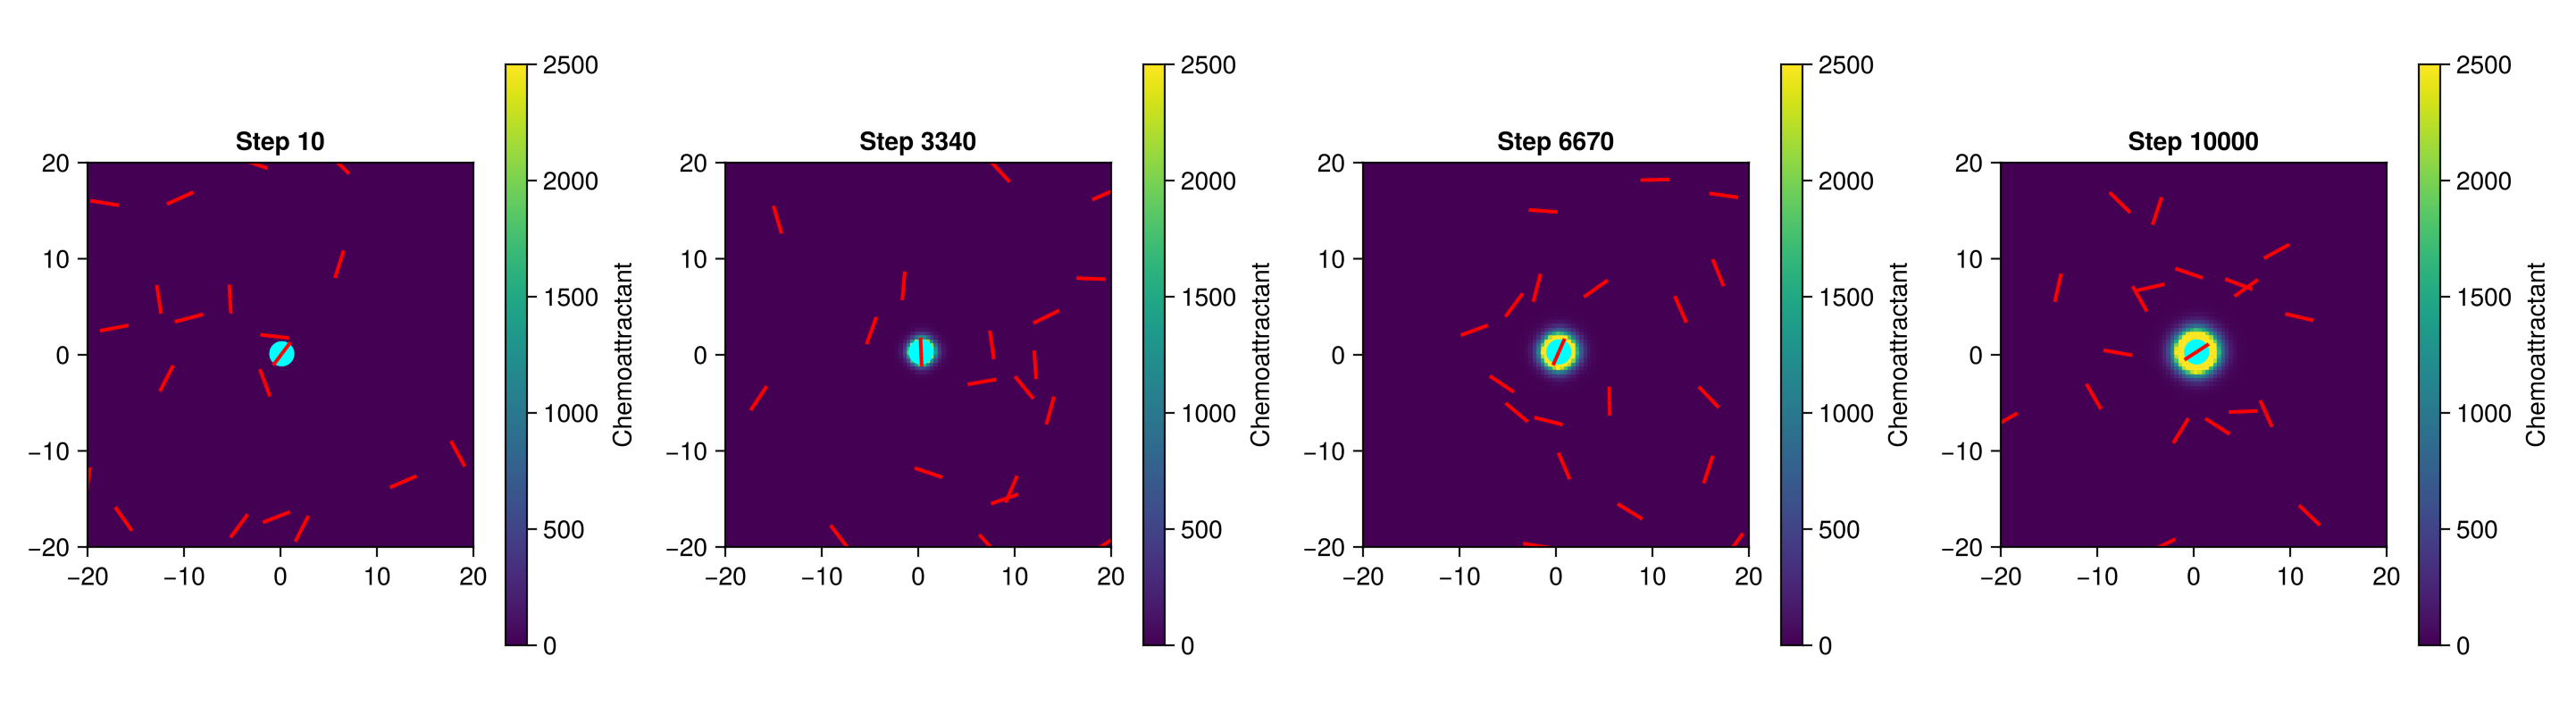

GLMakie.Screen(...)

In [200]:
steps_to_plot = unique(data.step)[1:round(Int, length(unique(data.step))/3):end]

fig = Figure(size=(1800, 400))

for (j, step) in enumerate(steps_to_plot)
    ax = Axis(fig[1, 2*j-1], aspect=1, title="Step $step")
    
    # Filter data for this step
    data_step = data[data.step .== step, :]
    
    # Extract and reshape medium grid
    mm_grid = reshape(data_step.mm_grid[1], (100, 100))
    
    # Plot heatmap

    hm = heatmap!(ax, 
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
                mm_grid, 
                colormap=:viridis,
                colorrange = (0, 2500.))
    xlims!(ax, com.simBox[1,:]...)
    ylims!(ax, com.simBox[2,:]...)
    
    # Plot source agents
    src_mask = data_step[data_step.isSource .== true, :id]
    scatter!(ax, data_step.x[src_mask], data_step.y[src_mask], color=:cyan, markersize=20, label="Source")
    
    # Plot rods as line segments
    x = data_step.x
    y = data_step.y
    theta = data_step.theta
    l = data_step.l
    
    # Compute rod endpoints
    xs1 = x .+ l ./ 2 .* cos.(theta)
    ys1 = y .+ l ./ 2 .* sin.(theta)
    xs2 = x .- l ./ 2 .* cos.(theta)
    ys2 = y .- l ./ 2 .* sin.(theta)

    # Plot rods as line segments
    for i in 1:length(x)
        linesegments!([Point2f(x[i], y[i]), Point2f(xs1[i], ys1[i])], color=:red, linewidth=2)
        linesegments!([Point2f(x[i], y[i]), Point2f(xs2[i], ys2[i])], color=:red, linewidth=2)
    end

    # Colorbar
    Colorbar(fig[1, 2*j], hm, label="Chemoattractant")
end

# Display
display(fig)


In [201]:
save("Bacteria_10000ts_DM_0_0001.png", fig)

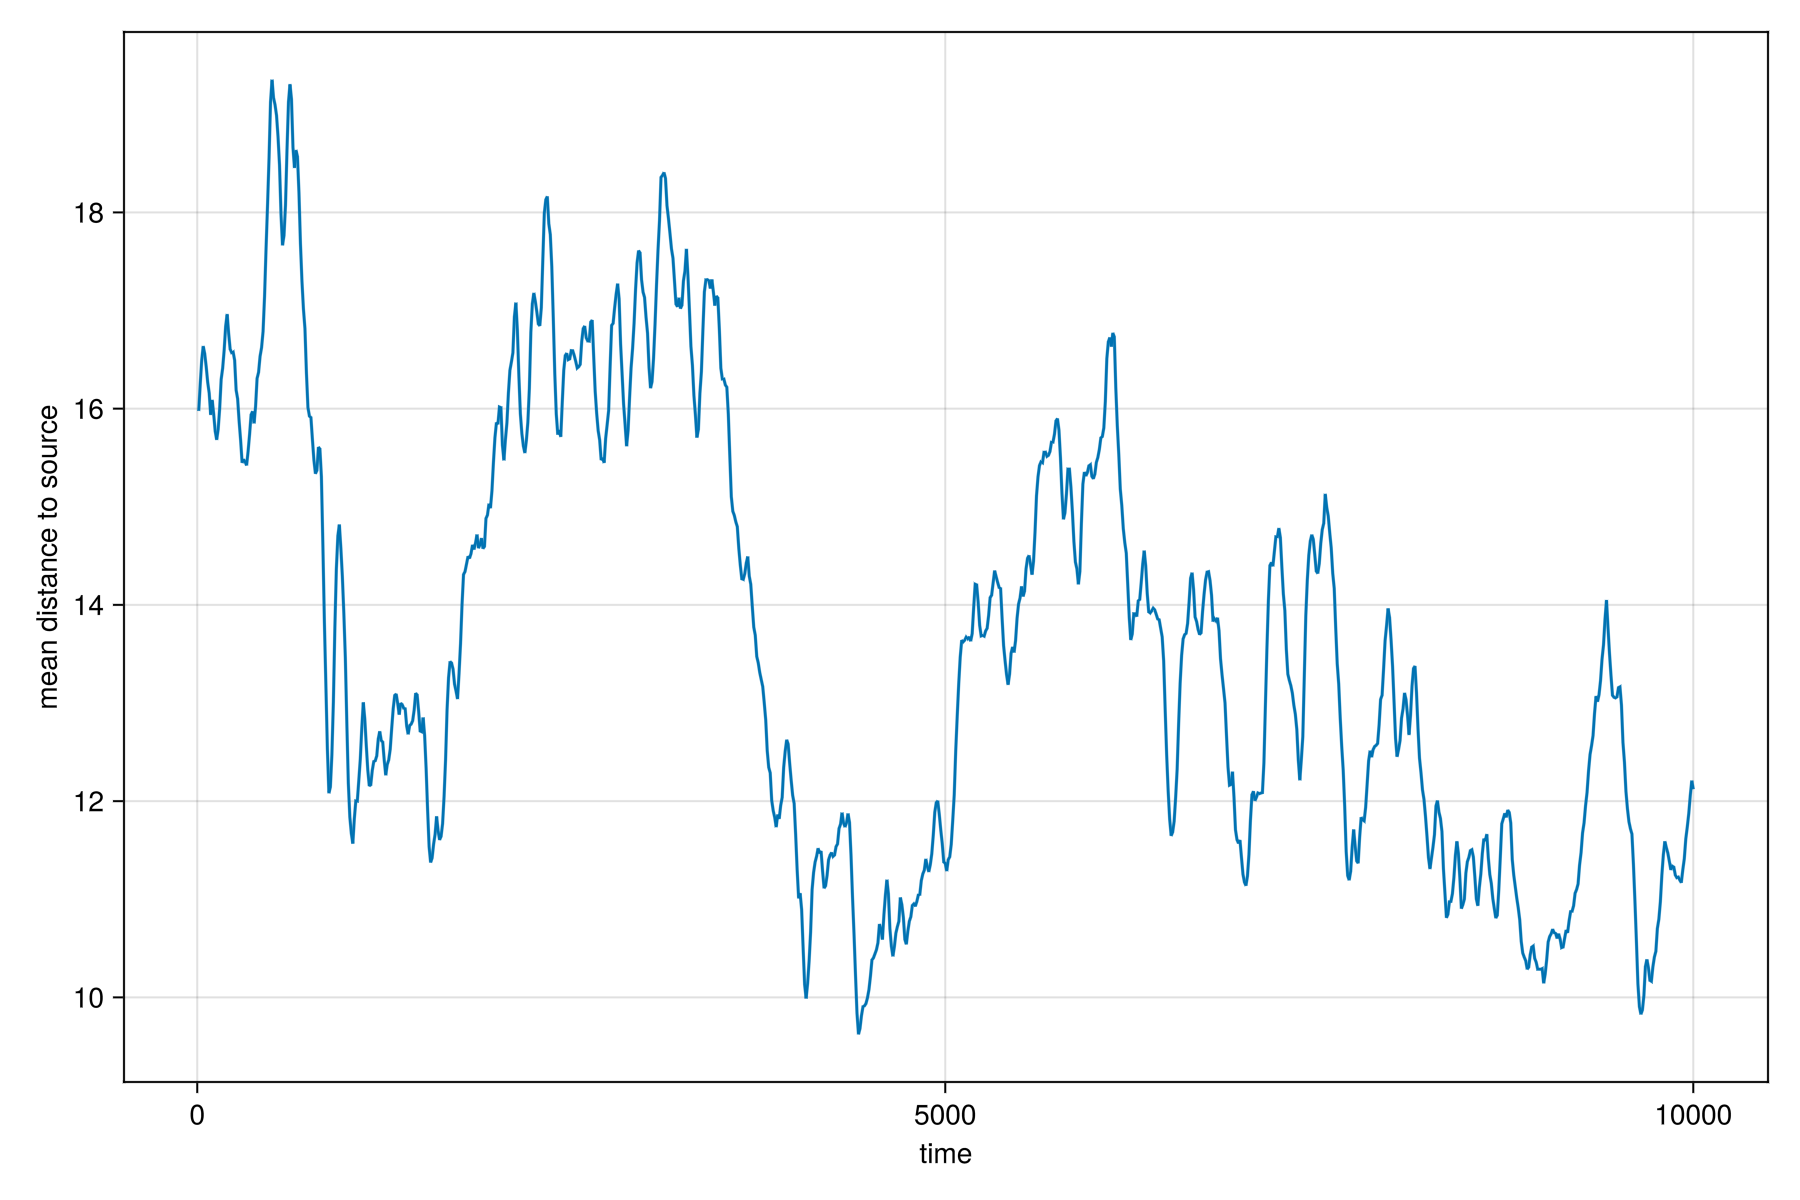

GLMakie.Screen(...)

In [3]:
# Plot mean distance to source
src_id = findfirst(data[!, :isSource][1])

mean_dist = Float64[]

for step in groupby(data, :step)

    # Source position at this step
    src = step[step.id .== src_id, :]
    isempty(src) && continue   # safety

    xs = src.x[1]
    ys = src.y[1]

    # Non-source bacteria
    others = step[step.isSource .== false, :]

    dists = sqrt.((others.x .- xs).^2 .+ (others.y .- ys).^2)

    push!(mean_dist, mean(dists))

end

fig = Figure(size=(900, 600))

ax1 = Axis(fig[1,1], xlabel="time", ylabel="mean distance to source")
lines!(ax1, unique(data[!, :step]), mean_dist)
# ax2 = Axis(fig[1,2], xlabel = "time", ylabel = "X distance")
# lines!(ax2, data[:, :step], data[:, :M])

display(fig)

In [4]:
save("Bacteria_10000ts_DM_0001_mean_distance.png", fig)

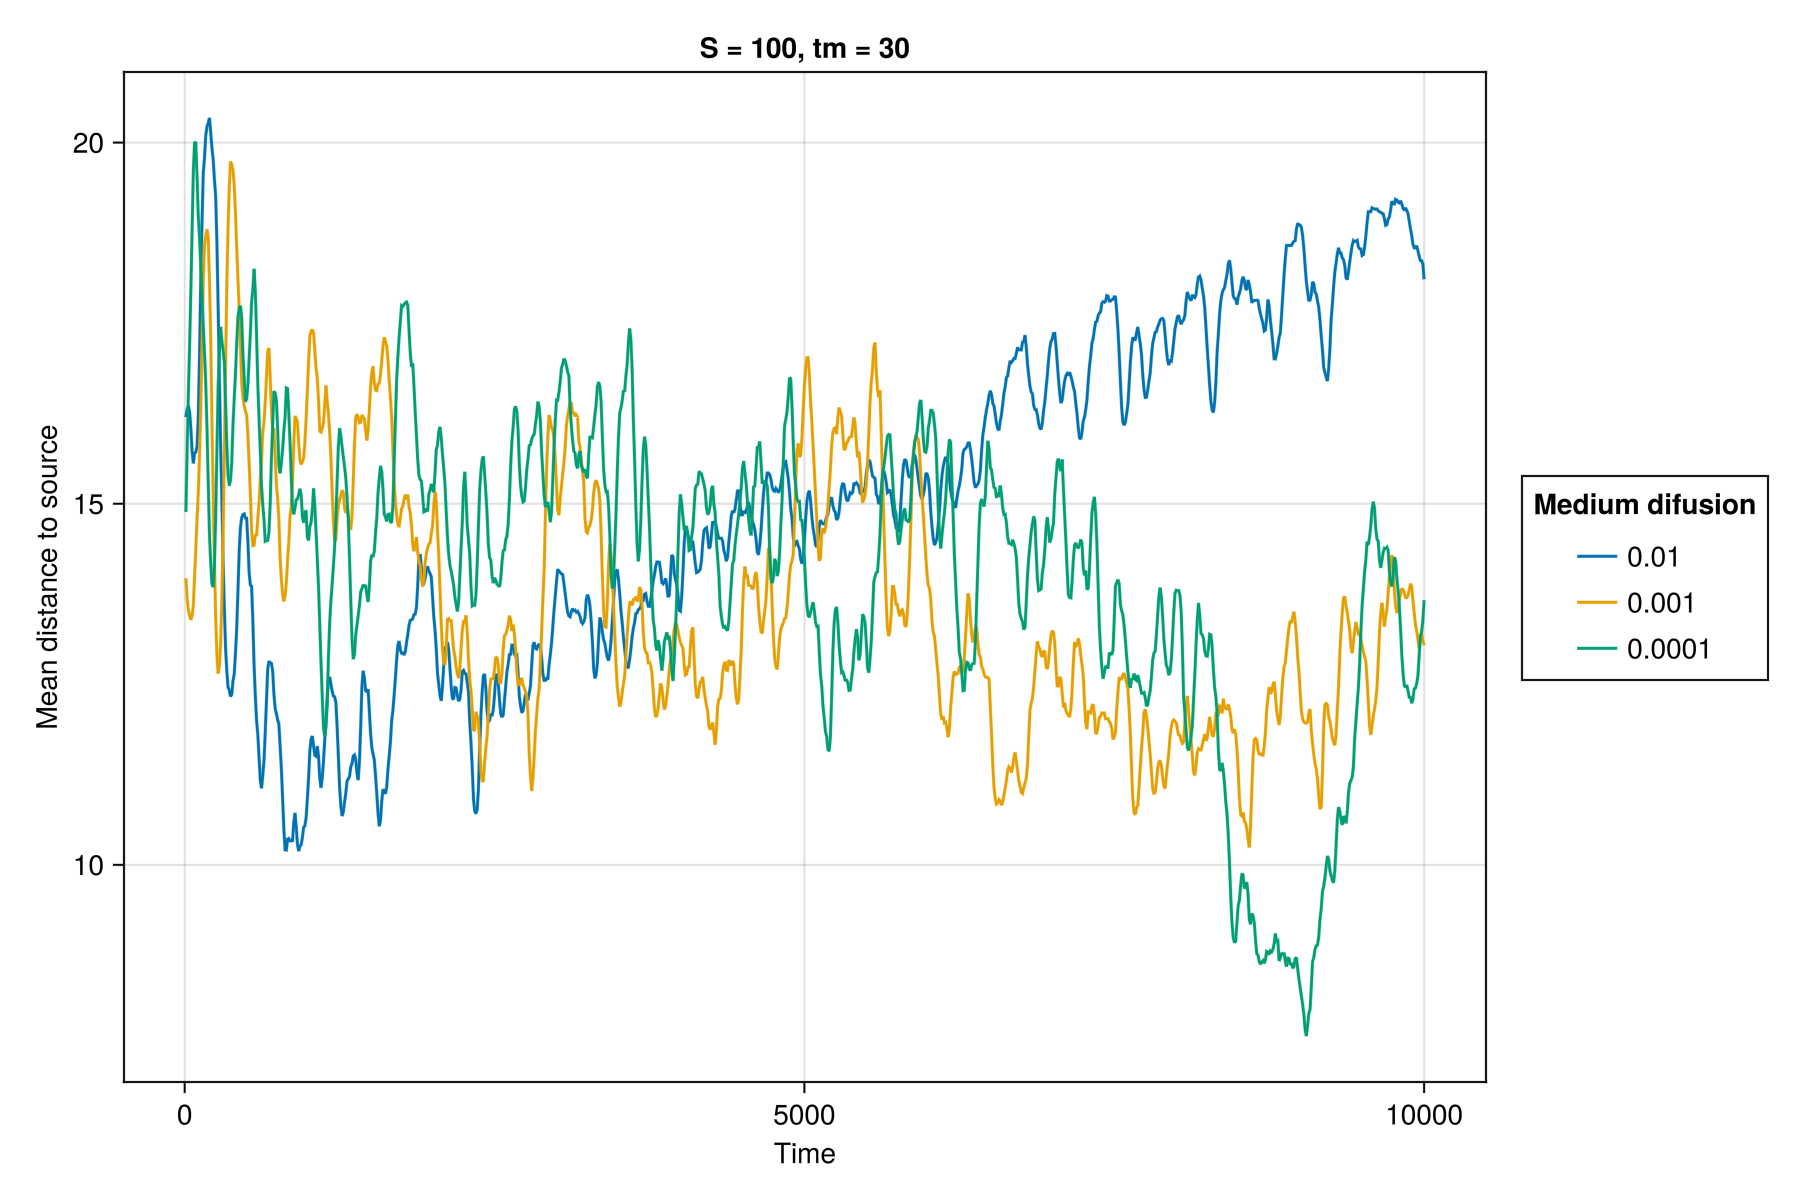

GLMakie.Screen(...)

In [190]:
fig = Figure(size=(900, 600))
dataframes = Dict{Int, DataFrame}(
    1 => CSV.read("def_DM001.csv", DataFrame),
    2 => CSV.read("def_DM0001.csv", DataFrame),
    3 => CSV.read("def_DM00001.csv", DataFrame)
    # 4 => CSV.read("def_DM00001.csv", DataFrame)
)

sources = Dict(
    1 => 10,
    2 => 100,
    3 => 1000
)

difusion = Dict(
    1 => 0.01,
    2 => 0.001,
    3 => 0.0001
)

adaptation_time = Dict(
    1 => 5,
    2 => 10,
    3 => 30
)

speed = Dict(
    1 => 0.1,
    2 => 1,
    3 => 2.5,
    4 => 5
)
ax1 = Axis(fig[1,1], xlabel="Time", ylabel="Mean distance to source", title = "S = 100, tm = 30")

for i in 1:3
    data = dataframes[i]
    src_id = findfirst(data[!, :isSource][1])
    difusion_med = difusion[i]
    # source_strength = sources[i]
    # adapt = adaptation_time[i]
    # velocity = speed[i]

    mean_dist = Float64[]

    for step in groupby(data, :step)

        # Source position at this step
        src = step[step.id .== src_id, :]
        isempty(src) && continue   # safety

        xs = src.x[1]
        ys = src.y[1]

        # Non-source bacteria
        others = step[step.isSource .== false, :]

        dists = sqrt.((others.x .- xs).^2 .+ (others.y .- ys).^2)

        push!(mean_dist, mean(dists))

    end

    lines!(ax1, unique(data[!, :step]), mean_dist, label = string(difusion_med))

end

fig[1, 2] = Legend(fig, ax1, "Medium difusion")

display(fig)

In [191]:
save("Mean_distance_def_DM.png", fig)

In [17]:
function plotRods2D!(ax, x, y, d, l, angle; kargs...)

    Main.meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )

    Main.meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=[Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(l,d)],
                rotation=angle,
                kargs...
            )

    return

end

function plotRods2D!(ax, x, y, xs1, ys1, xs2, ys2, markerSphere, markerCylinder, angle; kargs...)

    m = meshscatter!(ax,
                xs1,
                ys1,
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=markerSphere;
                kargs...
            )

    Main.meshscatter!(ax,
                xs2,
                ys2,
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=markerSphere;
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=markerCylinder,
                rotation=angle;
                kargs...
            )

    return m

end

plotRods2D! (generic function with 2 methods)